## Step 0. Folder Structure
```
3. Deep Learning Project/
├── dataset_split/
│   ├── train/
│   │   ├── african_elephant (780 images)
│   │   ├── airliner (780 images)
│   │   └── ... (8 more folders)
│   ├── val/
│   │   ├── african_elephant (260 images)
│   │   ├── airliner (260 images)
│   │   └── ... (8 more folders)
│   └── test (2600 images)
├── data_preprocessed/
│   ├── labels_train.pt
│   ├── labels_val.pt
│   ├── tensor_test.pt
│   ├── tensor_train.pt
│   └── tensor_val.pt
├── models/
│   ├── resnet18_checkpoint.pkl
│   └── resnet34_checkpoint.pkl
├── src/
│   └── part3.ipynb
├── src_datasplit/
│   └── data_split.ipynb
├── MSA.yaml
├── README.md
└── IEEE_Report_Template.docx
```


In [75]:
pip install tqdm matplotlib pandas opencv-python scikit-learn numpy

Python(38740) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


In [76]:
pip install torch torchvision

Python(38746) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


In [77]:
# TODO: Import the libraries.
from typing import Tuple, List
import os
import cv2
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import copy
import matplotlib.pyplot as plt
import csv
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import re

## Step 1 Preprocessing
1. Load images and labels from folders into lists.
2. Resize the images.
3. Convert the image data type as float32 and limit the range in [0, 1].
4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.
5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
6. Saving the pre-processed sets as .pt files in the correct directory.
7. Load the pre-processed sets from .pt files. 

In [78]:
def image_loader(set_dir: str) -> Tuple[List[np.ndarray], List[str]]:
    images = []
    labels = []
    is_test = all(os.path.isfile(os.path.join(set_dir, f)) for f in os.listdir(set_dir))

    if is_test:
        filenames = [f for f in os.listdir(set_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        filenames = sorted(filenames, key=lambda x: int(re.findall(r'\d+', x)[0]) if re.findall(r'\d+', x) else float('inf'))
        for fname in filenames:
            img_path = os.path.join(set_dir, fname)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
        labels = []
    else:
        for class_name in sorted(os.listdir(set_dir)):
            class_dir = os.path.join(set_dir, class_name)
            if os.path.isdir(class_dir):
                for fname in sorted(os.listdir(class_dir)):
                    if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                        img_path = os.path.join(class_dir, fname)
                        img = cv2.imread(img_path)
                        if img is not None:
                            images.append(img)
                            labels.append(class_name)
    return images, labels


In [79]:
def img_resize(images: List[np.ndarray], target_size: int = 224) -> np.ndarray:
    if not images:
        return np.array([])

    processed_images = []

    for img in images:
        if img is None or len(img.shape) != 3 or img.shape[2] not in [3, 4]:
            raise ValueError("Invalid image shape or number of channels")

        h, w = img.shape[:2]
        scale = target_size / min(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # Padding if needed
        pad_h = max(target_size - new_h, 0)
        pad_w = max(target_size - new_w, 0)
        if pad_h > 0 or pad_w > 0:
            top = pad_h // 2
            bottom = pad_h - top
            left = pad_w // 2
            right = pad_w - left
            resized = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0,0,0])
            new_h, new_w = resized.shape[:2]

        # Center crop
        start_x = (new_w - target_size) // 2
        start_y = (new_h - target_size) // 2
        cropped = resized[start_y:start_y + target_size, start_x:start_x + target_size]

        if cropped.shape != (target_size, target_size, 3):
            raise ValueError(f"Image has invalid shape after crop: {cropped.shape}")

        processed_images.append(cropped)

    return np.stack(processed_images)


In [80]:
# Load images

images_train, labels_train = image_loader('../dataset_split/train')
images_val, labels_val = image_loader('../dataset_split/val')
images_test, _= image_loader('../dataset_split/test')

In [81]:
# Resize the images

images_train = img_resize(images_train, 224)
images_val = img_resize(images_val, 224)
images_test = img_resize(images_test, 224)

In [82]:

# TODO: 3. Convert the image data type as float32 and limit the range in [0, 1].

images_train = images_train.astype(np.float32) / 255.0
images_val = images_val.astype(np.float32) / 255.0
images_test = images_test.astype(np.float32) / 255.0

In [83]:

# TODO: 4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.

tensor_train = torch.tensor(images_train.transpose(0, 3, 1, 2), dtype=torch.float32)
tensor_val = torch.tensor(images_val.transpose(0, 3, 1, 2), dtype=torch.float32)
tensor_test = torch.tensor(images_test.transpose(0, 3, 1, 2), dtype=torch.float32)

In [84]:

# TODO: 5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
train_mean = tensor_train.mean(dim=(0, 2, 3))
train_std = tensor_train.std(dim=(0, 2, 3))

tensor_train = (tensor_train - train_mean[None, :, None, None]) / train_std[None, :, None, None]
tensor_val = (tensor_val - train_mean[None, :, None, None]) / train_std[None, :, None, None]
tensor_test = (tensor_test - train_mean[None, :, None, None]) / train_std[None, :, None, None]

In [85]:
# TODO: 6. Save the pre-processed sets as .pt files.
os.makedirs("../data_preprocessed", exist_ok=True)

# 6.1 Save the tensor_train, tensor_val, and tensor_test as tensor_train.pt, tensor_val.pt, and tensor_test.pt, respectively.
torch.save(tensor_train, "../data_preprocessed/tensor_train.pt")
torch.save(tensor_val, "../data_preprocessed/tensor_val.pt")
torch.save(tensor_test, "../data_preprocessed/tensor_test.pt")
# 6.2 Create a list to map index to label and a dictionary to map label to index.
#   For instance:
#       unique_labels = ['african_elephant', 'airliner', ...]
#       label_to_index = {
#           'african_elephant': 0,
#           'airliner': 1,
#           ...
#       }

unique_labels = sorted(set(labels_train))

label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# 6.3 Map the labels to index.
labels_train_index = torch.tensor([label_to_index[label] for label in labels_train], dtype=torch.long)
labels_val_index = torch.tensor([label_to_index[label] for label in labels_val], dtype=torch.long)



# 6.4 Save the index, label_to_index, and index_to_label.
torch.save(labels_train_index, "../data_preprocessed/labels_train.pt")
torch.save(labels_val_index, "../data_preprocessed/labels_val.pt")
torch.save(label_to_index, "../data_preprocessed/label_to_index.pt")
torch.save(index_to_label, "../data_preprocessed/index_to_label.pt")


In [86]:
# TODO: 7. Load the pre-processed sets from .pt files. The data can be used directly in future without pre-processing once more by loading from the folder.

tensor_train = torch.load("../data_preprocessed/tensor_train.pt")
tensor_val = torch.load("../data_preprocessed/tensor_val.pt")
tensor_test = torch.load("../data_preprocessed/tensor_test.pt")

labels_train_index = torch.load("../data_preprocessed/labels_train.pt")
labels_val_index = torch.load("../data_preprocessed/labels_val.pt")

print("Train tensor:", tensor_train.shape)
print("Val tensor:", tensor_val.shape)
print("Test tensor:", tensor_test.shape)
print("Train labels:", labels_train_index.shape)
print("Val labels:", labels_val_index.shape)
print("Number of classes:", len(label_to_index))

Train tensor: torch.Size([7800, 3, 224, 224])
Val tensor: torch.Size([2600, 3, 224, 224])
Test tensor: torch.Size([2600, 3, 224, 224])
Train labels: torch.Size([7800])
Val labels: torch.Size([2600])
Number of classes: 10


# Step 2 Train the teacher model (ResNet34)
1. Set hyperparameters for the training process.
2. Create a pretrained ResNet34.
3. Define the optimizer, loss function, etc.
4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
5. Plot the loss and accuracy curves.

In [87]:

# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [88]:
# TODO: 1. Set hyperparameters for the training process.
MAX_EPOCH = 15
INIT_LR = 0.001
BATCH_SIZE = 64

# Specify the training device (automatically detects GPU if available)
# Device configuration
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [89]:
# TODO: 2. Create a pretrained ResNet34.
num_classes = len(torch.unique(labels_train_index))
# 2.1 Use torchvision to create a pretrained ResNet34.
resnet34 = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

# 2.2 Modify the output layer so that the model aligns with this project.
resnet34.fc = nn.Linear(resnet34.fc.in_features, num_classes)
# 2.2 Move the model to selected device.
resnet34 = resnet34.to(device)

print(resnet34)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [90]:
# TODO: 3. Define the optimizer, loss function, etc.

optimizer = optim.Adam(resnet34.parameters(), lr=INIT_LR)
criterion = nn.CrossEntropyLoss()

In [91]:
# TODO: 4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
# Hint: May not need too many epochs as this is a pretrained model.
train_dataset = TensorDataset(tensor_train, labels_train_index)
val_dataset = TensorDataset(tensor_val, labels_val_index)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_accs_resnet34, train_losses_resnet34 = [], []
val_accs_resnet34, val_losses_resnet34 = [], []
best_val_acc = 0.0

for epoch in range(MAX_EPOCH):
    # Training phase
    resnet34.train()
    running_train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet34(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        running_train_loss += loss.item() * inputs.size(0)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate training accuracy and loss
    train_acc = correct / total
    train_loss = running_train_loss / total
    train_losses_resnet34.append(train_loss)
    train_accs_resnet34.append(train_acc)
    
    # Validation phase
    resnet34.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet34(inputs)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = correct / total
    val_loss = running_val_loss / total
    val_losses_resnet34.append(val_loss)
    val_accs_resnet34.append(val_acc)

    print(f"Epoch {epoch+1}/{MAX_EPOCH} | "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f} | "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs("../models", exist_ok=True)
        torch.save(resnet34.state_dict(), "../models/resnet34_checkpoint.pkl")

Epoch 1/15 | Train Acc: 0.8277, Val Acc: 0.8458 | Train Loss: 0.5929, Val Loss: 0.4657
Epoch 2/15 | Train Acc: 0.9012, Val Acc: 0.8735 | Train Loss: 0.3144, Val Loss: 0.4538
Epoch 3/15 | Train Acc: 0.9185, Val Acc: 0.8327 | Train Loss: 0.2646, Val Loss: 0.6004
Epoch 4/15 | Train Acc: 0.9388, Val Acc: 0.8727 | Train Loss: 0.1916, Val Loss: 0.4303
Epoch 5/15 | Train Acc: 0.9521, Val Acc: 0.8838 | Train Loss: 0.1573, Val Loss: 0.3969
Epoch 6/15 | Train Acc: 0.9592, Val Acc: 0.8777 | Train Loss: 0.1308, Val Loss: 0.4538
Epoch 7/15 | Train Acc: 0.9659, Val Acc: 0.9023 | Train Loss: 0.1049, Val Loss: 0.3433
Epoch 8/15 | Train Acc: 0.9787, Val Acc: 0.8969 | Train Loss: 0.0691, Val Loss: 0.3808
Epoch 9/15 | Train Acc: 0.9805, Val Acc: 0.9015 | Train Loss: 0.0608, Val Loss: 0.3994
Epoch 10/15 | Train Acc: 0.9815, Val Acc: 0.8854 | Train Loss: 0.0639, Val Loss: 0.4297
Epoch 11/15 | Train Acc: 0.9724, Val Acc: 0.8812 | Train Loss: 0.0810, Val Loss: 0.4426
Epoch 12/15 | Train Acc: 0.9715, Val Acc:

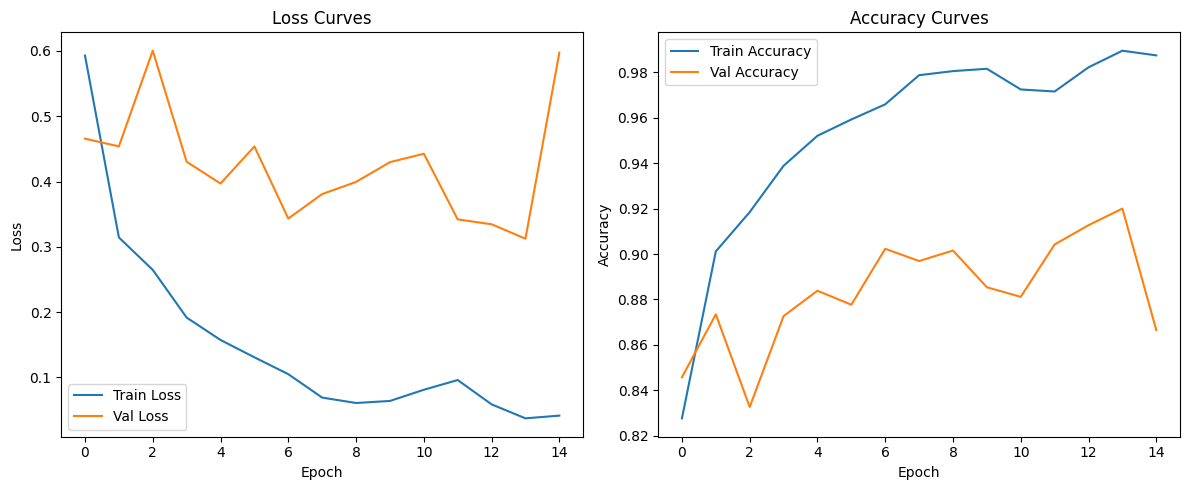

In [92]:
# TODO: 5. Plot the loss and accuracy curves.

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet34, label='Train Loss')
plt.plot(val_losses_resnet34, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs_resnet34, label='Train Accuracy')
plt.plot(val_accs_resnet34, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

# Step 3 Train the student model (ResNet18)
1. Set hyperparameters for the distillation process.
2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
3. Load the saved ResNet34 and move the model to selected device.
4. Define the optimizer, loss function, etc.
5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
6. Plot the loss and accuracy curves.

In [93]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [94]:
# TODO: 1. Set hyperparameters for the distillation process.

MAX_EPOCH = 15
INIT_LR = 0.001
BATCH_SIZE = 64

# Device configuration
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

TEMPERATURE = 4.0
LOSS_RATIO = 0.7  # 0.7 * distillation + 0.3 * classification loss

In [95]:
# TODO: 2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
num_classes = len(torch.unique(labels_train_index))
resnet18 = models.resnet18(weights=None)  # Non-pretrained ResNet18
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18 = resnet18.to(device)

In [96]:
# TODO: 3. Load the saved ResNet34 and move the model to selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet34 = models.resnet34(weights=None)
resnet34.fc = nn.Linear(resnet34.fc.in_features, num_classes)
resnet34.load_state_dict(torch.load("../models/resnet34_checkpoint.pkl", map_location=device))

resnet34 = resnet34.to(device)
resnet34.eval()  # Set to evaluation mode
for param in resnet34.parameters():
    param.requires_grad = False  # Freeze the parameters of ResNet34

In [97]:
# TODO: 4. Define the optimizer, loss function, etc.

# Define DistillationLoss class
class DistillationLoss(nn.Module):
    def __init__(self, temperature=4.0, alpha=0.7):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl = nn.KLDivLoss(reduction='batchmean')
        self.ce = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        soft_loss = self.kl(
            F.log_softmax(student_logits / self.temperature, dim=1),
            F.softmax(teacher_logits / self.temperature, dim=1)
        ) * (self.temperature ** 2)
        hard_loss = self.ce(student_logits, labels)
        return self.alpha * soft_loss + (1. - self.alpha) * hard_loss

# Initialize loss, optimizer, scheduler
criterion = DistillationLoss(temperature=TEMPERATURE, alpha=LOSS_RATIO)
optimizer = optim.Adam(resnet18.parameters(), lr=INIT_LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [98]:
# TODO: 5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
# Hint: Use the correct loss function for knowledge distillation.
#       Details can be fund in https://docs.pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html.

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

# Initialize lists to store training and validation metrics
train_accs_resnet18, train_losses_resnet18 = [], []
val_accs_resnet18, val_losses_resnet18 = [], []

best_val_acc = 0.0

for epoch in range(MAX_EPOCH):
    # Training phase
    resnet18.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, desc=f"[Epoch {epoch+1}/{MAX_EPOCH}] Training", leave=False)
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            teacher_logits = resnet34(images)

        student_logits = resnet18(images)
        loss = criterion(student_logits, teacher_logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        correct_train += (student_logits.argmax(1) == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix(loss=loss.item())

    train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses_resnet18.append(train_loss)
    train_accs_resnet18.append(train_acc)

    # Validation phase
    resnet18.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    val_bar = tqdm(val_loader, desc=f"[Epoch {epoch+1}] Validation", leave=False)
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            loss = F.cross_entropy(outputs, labels)

            total_val_loss += loss.item()
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

            val_bar.set_postfix(loss=loss.item())

    val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val / total_val
    val_losses_resnet18.append(val_loss)
    val_accs_resnet18.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}/{MAX_EPOCH} | "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f} | "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs("../models", exist_ok=True)
        torch.save(resnet18.state_dict(), "../models/resnet18_checkpoint.pkl")

Epoch 1/15 | Train Acc: 0.4888, Val Acc: 0.5785 | Train Loss: 10.3893, Val Loss: 2.3076


Epoch 2/15 | Train Acc: 0.6273, Val Acc: 0.5808 | Train Loss: 7.7916, Val Loss: 2.6400


Epoch 3/15 | Train Acc: 0.6994, Val Acc: 0.6577 | Train Loss: 6.2617, Val Loss: 2.1930


Epoch 4/15 | Train Acc: 0.7394, Val Acc: 0.6496 | Train Loss: 5.4352, Val Loss: 2.1664


Epoch 5/15 | Train Acc: 0.7694, Val Acc: 0.7677 | Train Loss: 4.5795, Val Loss: 1.2566


Epoch 6/15 | Train Acc: 0.8162, Val Acc: 0.8088 | Train Loss: 3.6325, Val Loss: 0.9265


Epoch 7/15 | Train Acc: 0.8395, Val Acc: 0.8269 | Train Loss: 3.2357, Val Loss: 0.8246


Epoch 8/15 | Train Acc: 0.8450, Val Acc: 0.8096 | Train Loss: 3.0359, Val Loss: 0.9170


Epoch 9/15 | Train Acc: 0.8656, Val Acc: 0.7842 | Train Loss: 2.6972, Val Loss: 1.1148


Epoch 10/15 | Train Acc: 0.8799, Val Acc: 0.7619 | Train Loss: 2.5043, Val Loss: 1.2672


Epoch 11/15 | Train Acc: 0.9110, Val Acc: 0.8388 | Train Loss: 1.9212, Val Loss: 0.7781


Epoch 12/15 | Train Acc: 0.9178, Val Acc: 0.8477 | Train Loss: 1.7577, Val Loss: 0.7538


Epoch 13/15 | Train Acc: 0.9297, Val Acc: 0.8392 | Train Loss: 1.5675, Val Loss: 0.8531


Epoch 14/15 | Train Acc: 0.9358, Val Acc: 0.8535 | Train Loss: 1.4335, Val Loss: 0.7107


Epoch 15/15 | Train Acc: 0.9469, Val Acc: 0.8462 | Train Loss: 1.2965, Val Loss: 0.7541


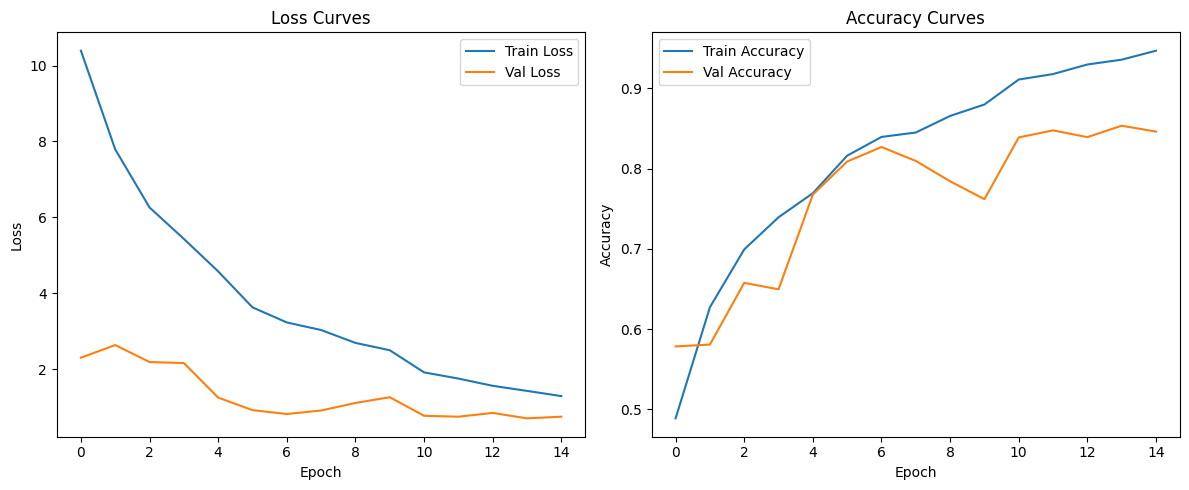

In [99]:
# TODO: 6. Plot the loss and accuracy curves.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet18, label='Train Loss')
plt.plot(val_losses_resnet18, label='Val Loss') 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()    

plt.subplot(1, 2, 2)
plt.plot(train_accs_resnet18, label='Train Accuracy')
plt.plot(val_accs_resnet18, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.show()

# Step 4 Predict labels in the testing set
1. Load the saved ResNet18 and move it to the selected device.
2. Do prediction using the images in the testing set.
3. Write the results into the CSV file for submission.

In [100]:
# TODO: 1. Load the saved ResNet18 and move it to the selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

# Load saved ResNet18 model and move to device
resnet18 = models.resnet18(weights=None)
resnet18.fc = nn.Linear(resnet18.fc.in_features, len(index_to_label))
resnet18.load_state_dict(torch.load("../models/resnet18_checkpoint.pkl", map_location=device))
resnet18 = resnet18.to(device)
resnet18.eval()  # Set to evaluation mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [103]:
# TODO: 2. Do prediction using the images in the testing set.
predictions = []

with torch.no_grad():
    for image in tqdm(tensor_test, desc="Predicting"):
        image = image.unsqueeze(0).to(device)  # Add batch dimension
        outputs = resnet18(image)
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted.item())

Predicting: 100%|██████████| 2600/2600 [00:30<00:00, 86.56it/s] 


In [102]:
# TODO: 3. Write the results into the CSV file for submission.
# Load index_to_label dictionary
index_to_label = torch.load("../data_preprocessed/index_to_label.pt")

# Write predictions to CSV
import pandas as pd

submission_data = {
    "file_name": [f"{i}.jpg" for i in range(len(predictions))],
    "label": [index_to_label[idx] for idx in predictions]
}

df = pd.DataFrame(submission_data)
df.to_csv("submission.csv", index=False)